In [1]:
%reset

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2" 
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from matplotlib import units
from tensorflow.keras.optimizers import Adam
import os
from glob import glob
import shutil
import time
from IPython.display import clear_output
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import shutil
import PIL
from tensorflow.keras import layers
import pickle
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
batch_size = 32
img_height = 150
img_width = 150
dtrain = tf.keras.utils.image_dataset_from_directory(
  '../vs/data/dataset/dog-cat/Test-Val-PetImages/train/',
  image_size=(img_height, img_width),
  color_mode="rgb",
  batch_size=batch_size)

dtest = tf.keras.utils.image_dataset_from_directory(
  '../vs/data/dataset/dog-cat/Test-Val-PetImages/val/',
  image_size=(img_height, img_width),
  color_mode="rgb",
  batch_size=batch_size)

Found 19925 files belonging to 2 classes.
Found 4985 files belonging to 2 classes.


In [4]:
class_names = dtrain.class_names
print(class_names)

['Cat', 'Dog']


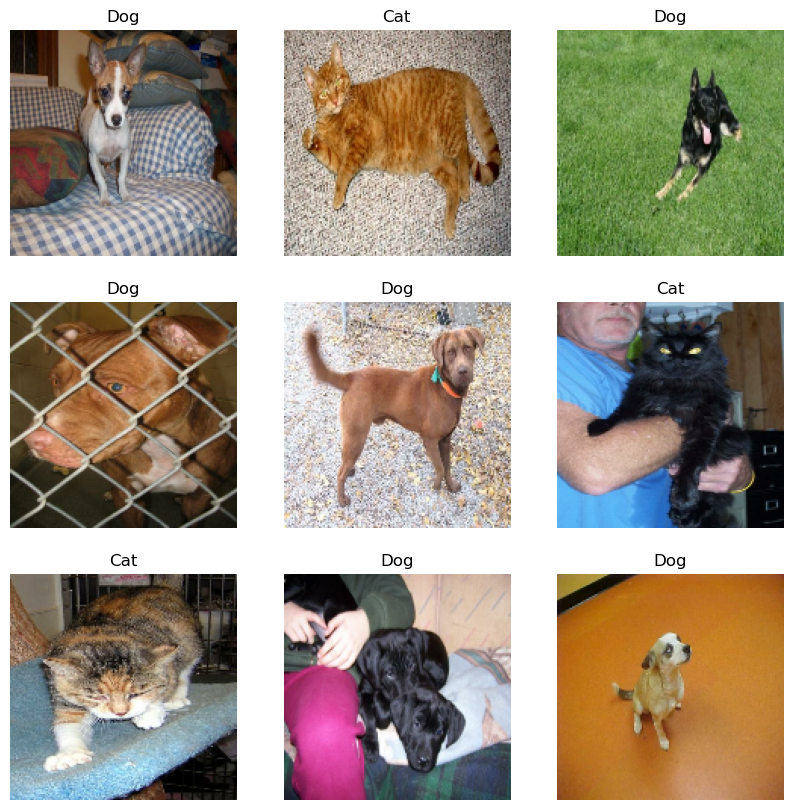

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in dtrain.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
dtrain = dtrain.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dtest = dtest.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
classes=len(class_names)
opt=tf.keras.optimizers.Adam(0.001)
model=tf.keras.models.Sequential()
model.add(layers.Rescaling(1./255,input_shape=(img_height, img_width, 3)))
model.add(layers.RandomFlip("horizontal",input_shape=(img_height, img_width, 3)))
model.add(layers.RandomRotation(0.1))
model.add(layers.RandomZoom(0.1))
model.add(layers.Conv2D(16,3,padding="same",activation="relu"))
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32,3,padding="same",activation="relu"))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(64,3,padding="same",activation="relu"))
model.add(layers.MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(classes))

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
history = model.fit(dtrain,validation_data=dtest,epochs=10)

Epoch 1/10
623/623 [==============================] - 162s 251ms/step - loss: 0.6702 - accuracy: 0.6045 - val_loss: 0.6002 - val_accuracy: 0.6792
Epoch 2/10
623/623 [==============================] - 169s 271ms/step - loss: 0.5806 - accuracy: 0.6965 - val_loss: 0.5224 - val_accuracy: 0.7376
Epoch 3/10
623/623 [==============================] - 189s 304ms/step - loss: 0.5441 - accuracy: 0.7267 - val_loss: 0.5200 - val_accuracy: 0.7314
Epoch 4/10
623/623 [==============================] - 192s 308ms/step - loss: 0.5162 - accuracy: 0.7454 - val_loss: 0.4645 - val_accuracy: 0.7823
Epoch 5/10
623/623 [==============================] - 193s 310ms/step - loss: 0.4872 - accuracy: 0.7625 - val_loss: 0.4490 - val_accuracy: 0.7876
Epoch 6/10
623/623 [==============================] - 191s 307ms/step - loss: 0.4716 - accuracy: 0.7749 - val_loss: 0.4426 - val_accuracy: 0.8010
Epoch 7/10
623/623 [==============================] - 191s 306ms/step - loss: 0.4500 - accuracy: 0.7875 - val_loss: 0.4230 -

In [9]:
model.save("../vs/data/model/modeldogcat.model")

In [10]:
model = tf.keras.models.load_model("../vs/data/model/modeldogcat.model")

This image used to be Cat 
but most likely belongs to Cat 
with a 53.15 percent confidence.


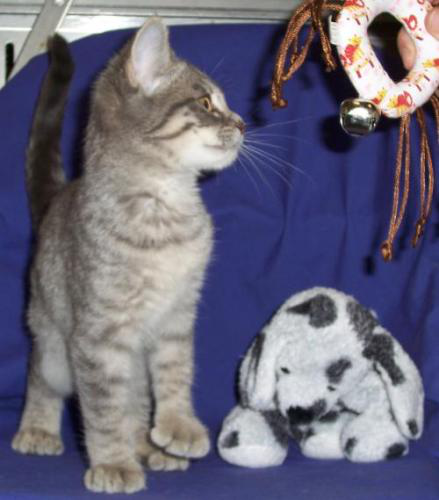

In [11]:
from random import random
img_paths = glob('../vs/data/dataset/dog-cat/Test-Val-PetImages/val/*/*.jpg')
ind=int(random()*len(img_paths)-1)
img = tf.keras.utils.load_img(
    img_paths[ind], target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image used to be {} \nbut most likely belongs to {} \nwith a {:.2f} percent confidence."
    .format(img_paths[ind].split("\\")[-2],class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(img_paths[ind])

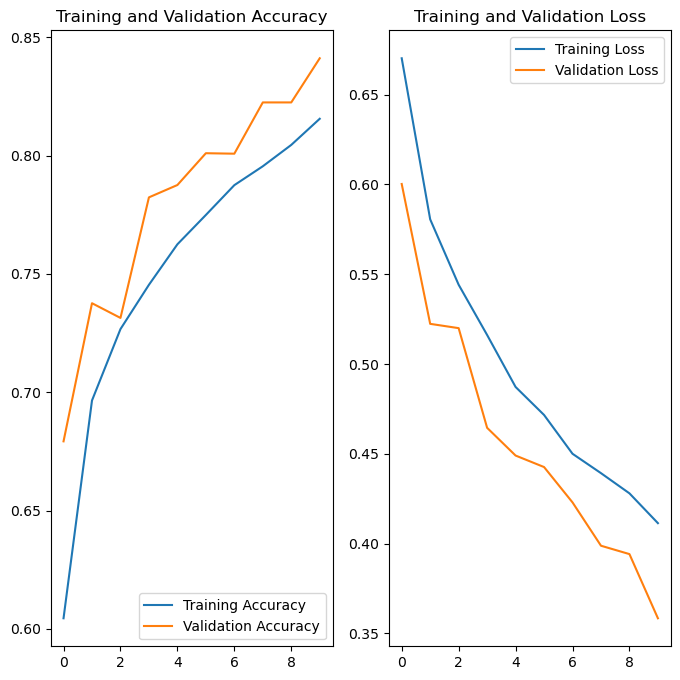

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
img_paths = glob('../vs/data/dataset/dog-cat/Test-Val-PetImages/*/*.jpg')
bad_paths = []

for image_path in img_paths:
    try:
      img_bytes = tf.io.read_file(image_path)
      decoded_img = tf.io.decode_image(img_bytes)
    except tf.errors.InvalidArgumentError as e:
      print(f"Found bad path {image_path}...{e}")
      bad_paths.append(image_path)
print("BAD PATHS:")
for bad_path in bad_paths:
    print(f"{bad_path}")

BAD PATHS:


In [14]:
#import splitfolders
#splitfolders.ratio('PetImages', output="./Test", seed=1337, ratio=(.8, 0.2))